<a href="https://colab.research.google.com/github/sudhirshahu51/projects/blob/master/stock_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Stock Price prediction using LSTM model

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, r2_score


Load data and plot

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Pytorch/data/goog.csv')

In [ ]:
data.index = pd.to_datetime(data['Date'])

In [ ]:
data

,Date,Open,High,Low,Close,Volume
Date,,,,,,
2016-12-19,12/19/2016,790.219971,797.659973,786.270020,794.200012,1225900
2016-12-20,12/20/2016,796.760010,798.650024,793.270020,796.419983,925100
2016-12-21,12/21/2016,795.840027,796.676025,787.099976,794.559998,1208700
2016-12-22,12/22/2016,792.359985,793.320007,788.580017,791.260010,969100
2016-12-23,12/23/2016,790.900024,792.739990,787.280029,789.909973,623400
...,...,...,...,...,...,...
2017-03-13,3/13/2017,844.000000,848.684998,843.250000,845.539978,1149500
2017-03-14,3/14/2017,843.640015,847.239990,840.799988,845.619995,779900
2017-03-15,3/15/2017,847.590027,848.630005,840.770020,847.200012,1379600


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 61 entries, 2016-12-19 to 2017-03-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    61 non-null     object 
 1   Open    61 non-null     float64
 2   High    61 non-null     float64
 3   Low     61 non-null     float64
 4   Close   61 non-null     float64
 5   Volume  61 non-null     int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 3.3+ KB


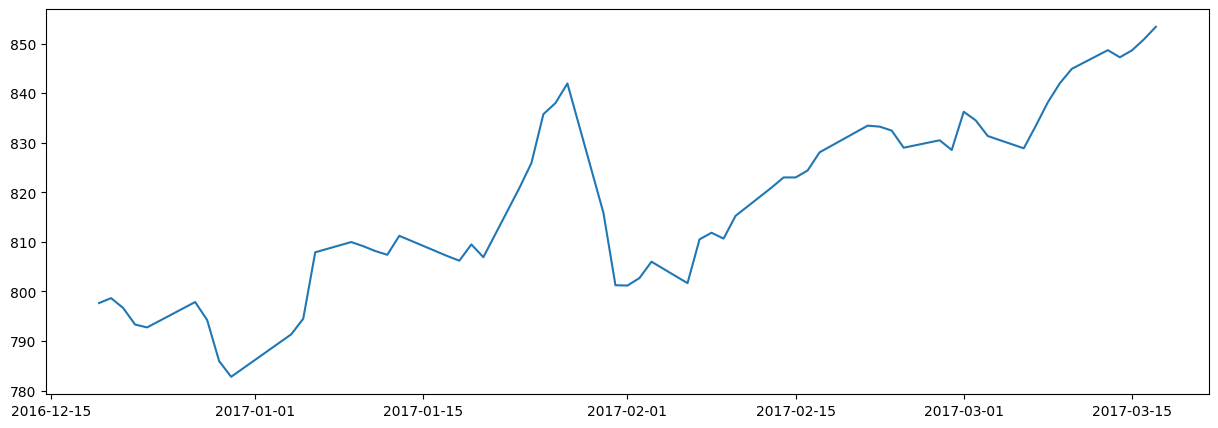

In [ ]:
plt.figure(figsize=[15,5])
plt.plot(data['High'])

In [ ]:
#get the data array
hi_data = data['High'].values

In [ ]:
#normalize the data
# Try log tranformation too
scaler = MinMaxScaler()
hi_data = scaler.fit_transform(hi_data.reshape(-1,1))

In [ ]:
# Prepare the sequence data for LSTM to train
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 20
X, y = create_sequences(hi_data, seq_length)

In [ ]:
X

array([[[0.2107044 ],
        [0.22472382],
        [0.19677141],
        [0.1492492 ],
        [0.14103599],
        [0.21353663],
        [0.16213469],
        [0.04460442],
        [0.        ],
        [0.09699768],
        [0.1212121 ],
        [0.16567476],
        [0.35570655],
        [0.38496143],
        [0.37312345],
        [0.35924663],
        [0.34848467],
        [0.40277502],
        [0.3449446 ],
        [0.33170475]],

       [[0.22472382],
        [0.19677141],
        [0.1492492 ],
        [0.14103599],
        [0.21353663],
        [0.16213469],
        [0.04460442],
        [0.        ],
        [0.09699768],
        [0.1212121 ],
        [0.16567476],
        [0.35570655],
        [0.38496143],
        [0.37312345],
        [0.35924663],
        [0.34848467],
        [0.40277502],
        [0.3449446 ],
        [0.33170475],
        [0.3780792 ]],

       [[0.19677141],
        [0.1492492 ],
        [0.14103599],
        [0.21353663],
        [0.16213469],
      

Splitting Data

In [ ]:
#Train Test split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, shuffle = False)

In [ ]:
#later can have error because of it just check.
X_train_t = torch.tensor(X_train).float()
X_test_t = torch.tensor(X_test).float()
Y_train_t = torch.tensor(Y_train).float()
Y_test_t =  torch.tensor(Y_test).float()

# Convert to PyTorch tensors
#X_train = torch.from_numpy(X_train).float()
#y_train = torch.from_numpy(y_train).float()
#X_test = torch.from_numpy(X_test).float()
#y_test = torch.from_numpy(y_test).float()



Define LSTM Model

In [ ]:
input_size =  1
hidden_layer_size = 100
output_size = 1

hidden_layer_size = 100
lstm = nn.LSTM(input_size, hidden_layer_size)
linear =  nn.Linear(hidden_layer_size, output_size)

hidden_cell = (torch.zeros(1, 1, hidden_layer_size),
               torch.zeros(1, 1, hidden_layer_size))

Resetting the hidden_cell to zero at the start of each sequence during training is crucial for several reasons:

Independence of Sequences: Each training sequence should be treated independently. By resetting the hidden state, we ensure that the model does not carry over information from one sequence to the next, which could lead to incorrect learning and dependencies that don't exist in the actual data.

Avoiding Gradient Issues: Carrying over hidden states without resetting can lead to issues with gradients, such as exploding or vanishing gradients, which can hinder the training process and make it unstable.

Consistent Training: Resetting the hidden state ensures that each sequence starts with the same initial conditions, making the training process more consistent and stable. This helps the model learn the patterns in the data more effectively.

**seq.view(len(seq), 1, -1)** Suppose seq is a tensor with shape (20,), representing a sequence of 20 time steps with a single feature per time step. The view operation reshapes it to (20, 1, 1), where:

20 is the sequence length,
1 is the batch size,
1 is the input size (number of features per time step).

**Why This Reshaping is Necessary**
LSTM models in PyTorch expect input data in the shape (seq_length, batch_size, input_size). By reshaping the tensor with seq.view(len(seq), 1, -1), we ensure that the data conforms to this expected shape, allowing the LSTM to process it correctly.

Train the model

In [ ]:
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(list(lstm.parameters()) + list(linear.parameters()), lr = 0.001)


epochs = 50

for i in range(epochs):
  for seq, labels in zip(X_train_t, Y_train_t):
    optimizer.zero_grad()
    hidden_cell = (torch.zeros(1, 1, hidden_layer_size),
               torch.zeros(1, 1, hidden_layer_size))
    lstm_out, hidden_cell = lstm(seq.view(len(seq), 1, -1), hidden_cell)
    y_pred = linear(lstm_out.view(len(seq), -1))[-1] #Relearn
    single_loss = loss_function(y_pred, labels)
    single_loss.backward()
    optimizer.step()

  if i % 10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

epoch:   1 loss: 0.05012735
epoch:  11 loss: 0.00535315
epoch:  21 loss: 0.00195652
epoch:  31 loss: 0.00100914
epoch:  41 loss: 0.00620434


In [ ]:
lstm.eval()
linear.eval()

Linear(in_features=100, out_features=1, bias=True)

In [ ]:
# Prepare test data
# Make predictions
predictions = []
for seq in X_test_t:
    with torch.no_grad():
        hidden_cell = (torch.zeros(1, 1, hidden_layer_size),
                       torch.zeros(1, 1, hidden_layer_size))
        lstm_out, hidden_cell = lstm(seq.view(len(seq), 1, -1), hidden_cell)
        predictions.append(linear(lstm_out.view(len(seq), -1))[-1].item())

# Inverse transform the predictions and actual values
predicted_stock_price = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
actual_stock_price = scaler.inverse_transform(Y_test_t.numpy().reshape(-1, 1))


In [ ]:
Y_test_t

tensor([[0.7169],
        [0.7841],
        [0.8386],
        [0.8798],
        [0.9332],
        [0.9128],
        [0.9325],
        [0.9639]])

In [ ]:
Y_test_t.numpy()

array([[0.716935  ],
       [0.7840555 ],
       [0.83857226],
       [0.8797784 ],
       [0.93323386],
       [0.9127721 ],
       [0.9324551 ],
       [0.96389055]], dtype=float32)

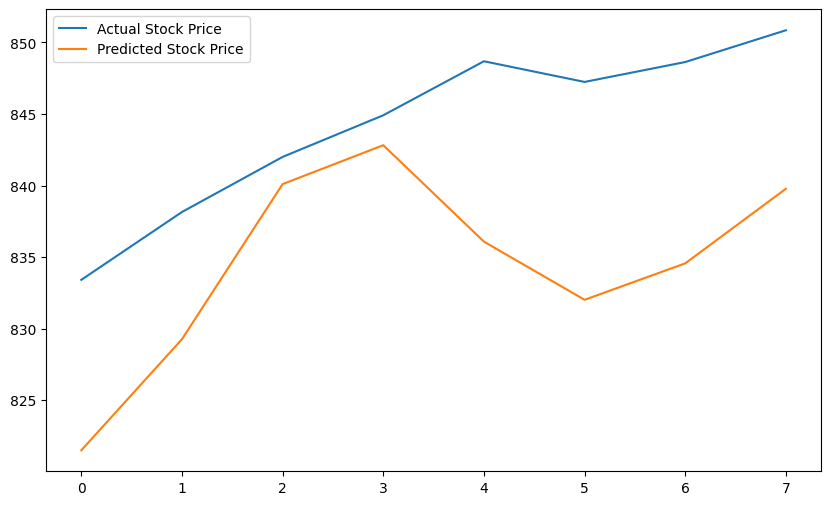

In [ ]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(actual_stock_price, label='Actual Stock Price')
plt.plot(predicted_stock_price, label='Predicted Stock Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
# Calculate evaluation metrics
mse = mean_squared_error(actual_stock_price, predicted_stock_price)
mae = mean_absolute_error(actual_stock_price, predicted_stock_price)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 117.53262543222647
Mean Absolute Error: 9.721342520526761
